In [175]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd
# Import the Keras libraries and packages
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

                                      ------------資料建置-----------

In [176]:
# Import the training set
pw2014_ini = pd.read_csv('homeF_2014_merge_2.csv')  # 讀取訓練集
pw2015_ini = pd.read_csv('homeF_2015_merge_2.csv')  # 讀取訓練集
power = pd.concat([pw2014_ini,pw2015_ini],axis=0,ignore_index=True)


In [177]:
power.head()

,Date & Time,Usage [kW],Generation [kW],WaterHeater [kW],Solar [kW],Refrigerator [kW],Microwave [kW],Furnace [kW],WaterHeater3 [kW],WaterHeater2 [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 00:00:00,0.977402,0.009264,0.296840,0.009264,0.059256,0.002800,0.008474,0.000531,0.020002,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
1,2014-01-01 00:15:00,0.377746,0.009904,0.063231,0.009904,0.003734,0.002914,0.008633,0.000471,0.009642,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
2,2014-01-01 00:30:00,0.420196,0.010133,0.001511,0.010133,0.121228,0.002630,0.008059,0.000044,0.000011,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
3,2014-01-01 00:45:00,0.290328,0.010029,0.000058,0.010029,0.016986,0.002910,0.008511,0.000411,0.000202,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
4,2014-01-01 01:00:00,0.307616,0.010038,0.000127,0.010038,0.014140,0.002691,0.008500,0.000400,0.000200,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0


In [178]:
#概況
target='Usage [kW]'
power[target].describe()

count    70080.000000
mean         1.315627
std          1.459243
min          0.000000
25%          0.438579
50%          0.815740
75%          1.284938
max         20.819441
Name: Usage [kW], dtype: float64

In [179]:
#drop掉NaN 讓dataframe變乾淨
cols=power.columns
power_empty=pd.DataFrame(columns=cols)#造一個空的dataframe
power_t=power.drop([35040,70081])
New_power= pd.concat([power_empty,power_t],axis=0,ignore_index=True)

In [180]:
training_set_1 = New_power.iloc[:, 1:2].values
training_set_2 = New_power.iloc[:, 1:2].values

In [181]:
#建立訓練集和測試集,基本上X_train跟X_train1是一樣的東西
training_set, dataset_test, training_set1, dataset_test1 = train_test_split(training_set_1, training_set_2, test_size=0.167,shuffle=False)

In [182]:
#標準化
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [221]:
X_train2 = []   #預測點的前 一個小時的資料
Y_train2 = []   #預測點
for i in range(16, 58376):  # 58376 是訓練集總數
    X_train2.append(training_set_scaled[i-16:i-3, 0])#往前shift8個data 相當於取得前2個小時的data
    Y_train2.append(training_set_scaled[i, 0])      #origin data
X_train3, Y_train3 = np.array(X_train2), np.array(Y_train2)  # 轉成numpy array的格式，以利輸入 RNN

In [222]:
X_train4 = np.reshape(X_train3, (X_train3.shape[0], X_train3.shape[1], 1))

In [223]:
LSTM_model = Sequential()

In [224]:
# Adding the first LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 40, return_sequences = True, input_shape = (X_train4.shape[1], 1)))
LSTM_model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 60, return_sequences = True))
LSTM_model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 60, return_sequences = True))
LSTM_model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 60, return_sequences = True))
LSTM_model.add(Dropout(0.2))

# 由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 return_sequences 設為預設值 False （也就是不用寫上 return_sequences）
LSTM_model.add(LSTM(units = 40))
LSTM_model.add(Dropout(0.2))

In [225]:
# Adding the output layer
LSTM_model.add(Dense(units = 1))

In [226]:
# Compiling
LSTM_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

# 進行訓練
LSTM_model.fit(X_train4, Y_train3, epochs = 100, batch_size = 32)

Epoch 1/100
58360/58360 [==============================] - 92s 2ms/step - loss: 0.0361
Epoch 2/100
58360/58360 [==============================] - 85s 1ms/step - loss: 0.0315
Epoch 3/100
58360/58360 [==============================] - 90s 2ms/step - loss: 0.0304
Epoch 4/100
58360/58360 [==============================] - 89s 2ms/step - loss: 0.0300
Epoch 5/100
58360/58360 [==============================] - 88s 2ms/step - loss: 0.0297
Epoch 6/100
58360/58360 [==============================] - 90s 2ms/step - loss: 0.0295
Epoch 7/100
58360/58360 [==============================] - 90s 2ms/step - loss: 0.0293
Epoch 8/100
58360/58360 [==============================] - 91s 2ms/step - loss: 0.0291
Epoch 9/100
58360/58360 [==============================] - 86s 1ms/step - loss: 0.0290
Epoch 10/100
58360/58360 [==============================] - 91s 2ms/step - loss: 0.0289
Epoch 11/100
58360/58360 [==============================] - 84s 1ms/step - loss: 0.0287
Epoch 12/100
58360/58360 [===============

In [252]:
dataset_total = New_power['Usage [kW]']
inputs = dataset_total[len(dataset_total) - len(dataset_test) -16 :].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test1 = []
for i in range(16, 1016):  # X_test資料
    X_test1.append(inputs[i-16:i-3, 0])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1)) 


In [260]:
X_test1_MAE = []
for i in range(16, 10016):  # X_test資料
    X_test1_MAE.append(inputs[i-16:i-3, 0])
X_test1_MAE = np.array(X_test1_MAE)
X_test1_MAE = np.reshape(X_test1_MAE, (X_test1_MAE.shape[0], X_test1_MAE.shape[1], 1)) 


In [254]:
X_test= dataset_test[0:1000]


In [255]:
X_test_MAE= dataset_test[0:10000]


In [256]:
predicted_stock_price = LSTM_model.predict(X_test1)       # 預測結果(此為還原前的值)
Y_predicted = sc.inverse_transform(predicted_stock_price)  # 得到原始值

In [261]:
predicted_stock_price_MAE = LSTM_model.predict(X_test1_MAE)       # 預測結果(此為還原前的值)
Y_predicted_MAE = sc.inverse_transform(predicted_stock_price_MAE)  # 得到原始值

**X_test1相當於LI中的X_test ,Y_predicted相當於Y_pred,dataset_test相當於Y_test也就是實際值,X_train就是往前shift四個data的值**


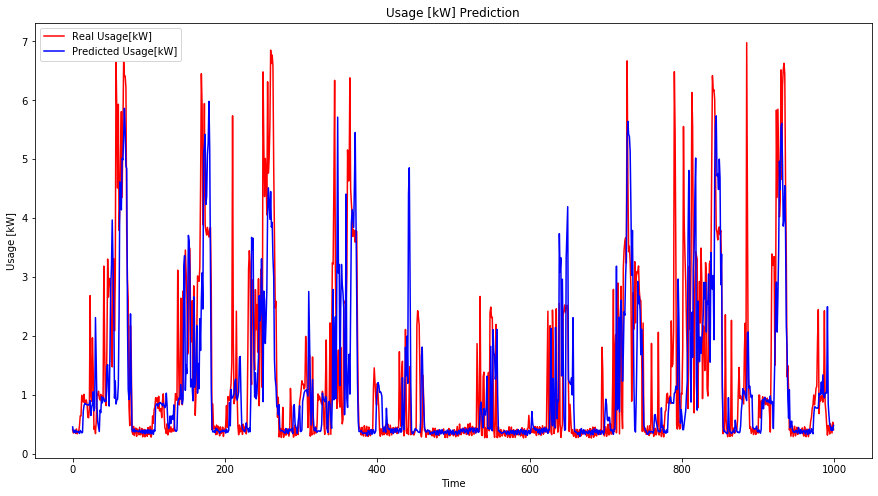

In [263]:
# 視覺化
plt.figure(figsize=(15,8))
plt.plot(X_test, color = 'red', label = 'Real Usage[kW]')  # 紅線表示Usage
plt.plot(Y_predicted, color = 'blue', label = 'Predicted Usage[kW]')  # 藍線表示預測Usage
plt.title('Usage [kW] Prediction')
plt.xlabel('Time')
plt.ylabel('Usage [kW]')
plt.legend()
plt.show()


In [262]:
print('*Mean Absolute Error:', metrics.mean_absolute_error(X_test_MAE, Y_predicted_MAE))  

*Mean Absolute Error: 0.4913072368939003
